In [5]:
import os, sys
print( os.getcwd() )
os.listdir( os.getcwd() ) 

/home/topolo/PropD/MLgrabbag/kaggle


['2017datascibowl',
 'data_password.txt',
 'LSTM_model201702271930.save',
 'cleaning_dueSigmaFin.pyc',
 'LSTM_model201702280608.save',
 'DatSciBow2017_DNN.ipynb',
 '.ipynb_checkpoints',
 'dueSigmaFinancial_kaggle.py',
 'HOG_process.ipynb',
 'LSTM_model.save',
 'LSTM_model201703012346.save',
 'DatSciBow2017_FullPreprocessTutorial.ipynb',
 'LSTM_model201702282350.save',
 'GRU_model201703022010.save',
 'DueSigmaFin_runs.ipynb',
 'ImagePreprocessing.ipynb',
 'dueSigmaFinancial_local.ipynb',
 'GRU_model201703012348.save',
 'GRU_model201703050709.save',
 'GRU_model201703021741.save',
 'kaggle.ipynb',
 'glass.csv',
 'DatSciBow2017_SVM.ipynb',
 '__init__.py',
 'train.h5',
 'dueSigmaFinancial_local_GRUs.ipynb',
 'cleaning_dueSigmaFin.py']

In [25]:
INPUT_FOLDER='./2017datascibowl/stage1/'

In [63]:
from skimage.feature import hog
from skimage import exposure

In [6]:
%matplotlib inline

In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

In [8]:
# Load the scans in given folder path
def load_scan(path):
    """
    INPUTS/ARGUMENTS 
    ================
    @type path : Python string
    
    @type slices : Python list (for each file in a folder/directory of dicom.dataset.FileDataset  
    each is a slice of the single patient's lung
    """
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [9]:
def slices_per_patient(input_folder_path):
    """ slices_per_patient
    @type input_folder_path : Python string 
    """
    patients = os.listdir(input_folder_path)
    patients.sort()
    
    patient_slices_lst = []
    
    for patient in patients:
        Nz = len( os.listdir(input_folder_path + patient))
        patient_slices_lst.append(Nz)
        
    return patient_slices_lst

In [10]:
def get_pixels_hu(slices):
    """
    INPUTS/ARGUMENTS
    ================
    @type slices : Python list of dicom.dataset.FileDataset, 
    @param slices : each dicom.dataset.FileDataset representing an image "slice" of a single patient's lung
    """
    image = np.stack([s.pixel_array for s in slices]) # np.array image.shape (134,512,512)
    # Convert to int16 (from sometimes int16),
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)
    
    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    # suggested by Henry Wolf to avoid -2048 values
    outside_of_image_val = image.min()
    image[image == outside_of_image_val] = 0 
    
    image[image == -2000] = 0 
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
        
    return np.array(image, dtype=np.int16)

In [11]:
def resample_given_dims(image, scan, new_shape):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)  # (\Delta z,\Delta x,\Delta y)
    
    real_resize_factor=new_shape/np.array(image.shape).astype("float32")  
    
    new_spacing = spacing/real_resize_factor # (\Delta z',\Delta x',\Delta y')
        
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [12]:
def norm_zero_images(patient_image,MIN_BOUND,MAX_BOUND,PIXEL_MEAN=0.25):
    """ norm_zero_images - due normalization and zero center on a 3-dim. numpy array/matrix that 
    represents all (total) 2-dim. image slices for a single patient"""
    Nz = patient_image.shape[0]
    new_patient_image = []
    for z_idx in range(Nz):
        patient_normed=normalize(patient_image[z_idx],MIN_BOUND,MAX_BOUND)
        patient_normed=zero_center(patient_normed,PIXEL_MEAN)
        new_patient_image.append( patient_normed)
    new_patient_image=np.array(new_patient_image)
    return new_patient_image
    

In [13]:
def normalize(image,MIN_BOUND,MAX_BOUND):
    image = (image - MIN_BOUND)/(MAX_BOUND-MIN_BOUND)
    image[image>1]=1.
    image[image<0]=0.
    return image   

In [14]:
def zero_center(image, PIXEL_MEAN):
    image = image - PIXEL_MEAN
    return image

In [50]:
def process_patient(patientname,    
                                MIN_BOUND=-1000.0,
                                MAX_BOUND=500.0,
                                PIXEL_MEAN=0.25,
                                INPUT_FOLDER='./2017datascibowl/stage1/',
                                N_x=512,N_y=512,):
    """ process_patient - process single patient """
    patient = load_scan(INPUT_FOLDER +patientname)
    
    Nz_lst = slices_per_patient( INPUT_FOLDER )
    Nz_tot= int( pd.DataFrame(Nz_lst).median() )
    patient_pixels = get_pixels_hu(patient)
    
    patient_resampled,spacing_new=resample_given_dims(patient_pixels,patient,[Nz_tot,N_x,N_y]) 
    patient_resampled_norm=norm_zero_images(patient_resampled,MIN_BOUND,MAX_BOUND,PIXEL_MEAN)
    
    return patient_resampled_norm,patient[0].ImagePositionPatient[:2], patient[0].ImageOrientationPatient

In [115]:
def slices_to_HOG(slices,orientations=8,pixels_per_cell=(16,16),cells_per_block=(1,1) ):
    """ numpy array of image slices (so 3-tensor of Nz x 512 x 512) to HOG, histogram of Oriented Gradients 
    """
    Nz = slices.shape[0]
    new_slices=[]
    for z in range(Nz):
        slice_fd,slice_img=hog(slices[z],orientations=orientations,pixels_per_cell=pixels_per_cell,
                                cells_per_block=cells_per_block,visualise=True)
        new_slices.append(slice_fd)
    new_slices=np.array(new_slices)
    return new_slices


In [16]:
def save_feat_vec(patient_feature_vec,patientname,sub_name="stage1_feat"):
#def save_feat_vec(patient_feature_vec,patientname): original
    #    f=file( "./2017datascibowl/stage1_feat/"+patientname + "feat_vec" ,"wb")
    f=file( "./2017datascibowl/"+sub_name+"/"+patientname + "feat_vec" ,"wb")
    np.save(f,patient_feature_vec)
    f.close()

In [17]:
patients_stage1 = os.listdir('./2017datascibowl/stage1')
print(len(patients_stage1))

1595


In [124]:
for patient_name in patients_stage1:
    patient_img,img_pos,img_orient = process_patient(patient_name)
    patient_fd = slices_to_HOG(patient_img)
    patient_feature_vec = np.concatenate( [patient_fd.flatten(), 
                                            np.array(img_pos),np.array(img_orient)])
    save_feat_vec( patient_feature_vec, patient_name,sub_name="stage1_HOG")

# Get the $y$ value (outcomes), the label for the class that each example belongs to, by matching patient IDs

In [69]:
y_ids = pd.read_csv('./2017datascibowl/stage1_labels.csv')
print(len(y_ids))

1397


In [39]:
patient=get_pixels_hu( load_scan(INPUT_FOLDER+patients_stage1[6]) )

(162, 512, 512)


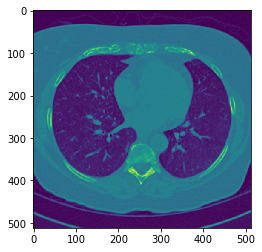

In [46]:
print( patient.shape)
plt.imshow( patient[75] )

In [51]:
patient_vec,patient_pos,patient_orient = process_patient(patients_stage1[6])

In [119]:
patient_fd=slices_to_HOG(patient_vec)

In [122]:
patient_fd.shape

(160, 8192)

In [120]:
patient_pos

['-148.70703', '-307.70703']

In [121]:
patient_orient

['1', '0', '0', '0', '1', '0']

(160, 512, 512)
['-148.70703', '-307.70703']
['1', '0', '0', '0', '1', '0']


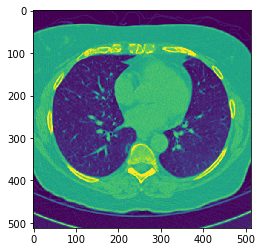

In [98]:
print(patient_vec.shape)
print(patient_pos)
print(patient_orient)
plt.imshow( patient_vec[75])

In [59]:
patient_fd,patient_hog_img=hog(patient_vec[70],orientations=8,pixels_per_cell=(32,32),
                               cells_per_block=(1,1),visualise=True)

In [60]:
patient_fd.shape

(2048,)

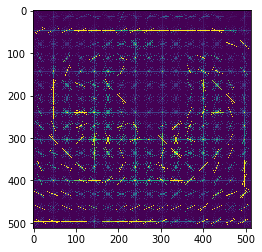

In [66]:
plt.imshow(exposure.rescale_intensity(patient_hog_img,in_range=(0,0.02)))

(8192,)


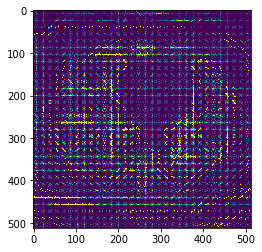

In [67]:
patient_fd16,patient_hog_img16=hog(patient_vec[70],orientations=8,pixels_per_cell=(16,16),
                               cells_per_block=(1,1),visualise=True)
print(patient_fd16.shape)
plt.imshow(exposure.rescale_intensity(patient_hog_img16,in_range=(0,0.02)))

(4096,)


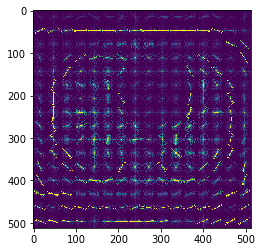

In [68]:
patient_fdO16,patient_hog_imgO16=hog(patient_vec[70],orientations=16,pixels_per_cell=(32,32),
                               cells_per_block=(1,1),visualise=True)
print(patient_fdO16.shape)
plt.imshow(exposure.rescale_intensity(patient_hog_imgO16,in_range=(0,0.02)))

(32768,)


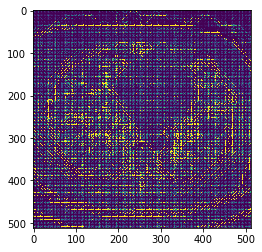

In [106]:
patient_fd8,patient_hog_img8=hog(patient_vec[70],orientations=8,pixels_per_cell=(8,8),
                               cells_per_block=(1,1),visualise=True)
print(patient_fd8.shape)
plt.imshow(exposure.rescale_intensity(patient_hog_img8,in_range=(0,0.02)))

In [71]:
y_ids.loc[ y_ids["id"] == patients_stage1[6]]

,id,cancer
1081,c5f73cf44d785e5ac2e7f0a8897f683c,0


In [93]:
y_ids.loc[ y_ids["id"] == patients_stage1[1071]]

,id,cancer
248,2ed8eb4430bf40f5405495a5ec22a76d,1


In [94]:
patientc=get_pixels_hu( load_scan(INPUT_FOLDER+patients_stage1[1071]) )

(130, 512, 512)


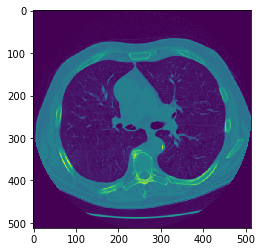

In [95]:
print( patientc.shape)
plt.imshow( patientc[75] )

In [96]:
patientc_vec,patientc_pos,patientc_orient = process_patient(patients_stage1[1071])

(160, 512, 512)
['-170.600006', '-191.399994']
['1.000000', '0.000000', '0.000000', '0.000000', '1.000000', '0.000000']


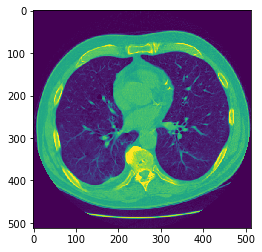

In [97]:
print(patientc_vec.shape)
print(patientc_pos)
print(patientc_orient)
plt.imshow( patientc_vec[70])

In [110]:
patientc_vec

(160, 512, 512)

(32768,)


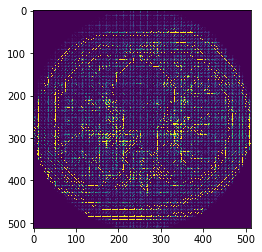

In [102]:
patientc_fd16,patientc_hog_img16=hog(patientc_vec[70],orientations=8,pixels_per_cell=(8,8),
                               cells_per_block=(1,1),visualise=True)
print(patientc_fd16.shape)
plt.imshow(exposure.rescale_intensity(patientc_hog_img16,in_range=(0,0.04)))

(12288,)


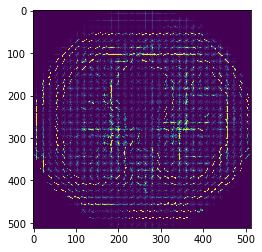

In [107]:
patientc_fd16,patientc_hog_img16=hog(patientc_vec[70],orientations=12,pixels_per_cell=(16,16),
                               cells_per_block=(1,1),visualise=True)
print(patientc_fd16.shape)
plt.imshow(exposure.rescale_intensity(patientc_hog_img16,in_range=(0,0.04)))

In [116]:
patientc_slices = slices_to_HOG(patientc_vec)

In [117]:
patientc_slices.shape

(160, 8192)